In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from utils import extract_time
from utils import random_generator
from utils import MinMaxScaler
from utils import sine_data_generation
from utils import visualization

from modules_and_training import TimeGAN
from modules_and_training import Time_GAN_module

## Real Data Time Series (EEG dataset)



This Notebook generates data for the eeg dataset 

In [ ]:
import pandas as pd
import numpy as np
import torch

# Helper Functions

In [ ]:
def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['stock','energy', 'eeg']
  
  if data_name == "eeg":
    ori_data = pd.read_csv("data/eeg.csv")
  else:
    if data_name == 'stock':
      ori_data = np.loadtxt('data/stock_data.csv', delimiter = ",",skiprows = 1)
    elif data_name == 'energy':
      ori_data = np.loadtxt('data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  if data_name != "eeg":
    ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  if data_name != "eeg":
    MAX_ROWS = len(ori_data) - seq_len
  else:
    MAX_ROWS = seq_len*500

  for i in range(0, min(len(ori_data) - seq_len, MAX_ROWS)):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    if (data_name != "eeg"):
       data.append(temp_data[idx[i]])
    else:
       if (temp_data[idx[i]]).isna().sum().sum() == 0: #no NAs
          data.append(temp_data[idx[i]].to_numpy())   
    
  return data



Parameters

In [ ]:
seq_len, dim = 24, 7
no = 2212

parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 40
parameters['num_layers'] = 1
parameters['iterations'] = 100
parameters['batch_size'] = 553
parameters['epoch'] = 2

data = torch.Tensor(data)


Start Embedding Network Training
step: 1/2, e_loss: 17.026407
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 1/2, s_loss: 0.16722645
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/2, D_loss: 3.9022648, G_loss_U: 0.22096132, G_loss_S: 0.028199883, E_loss_t0: 17.015446


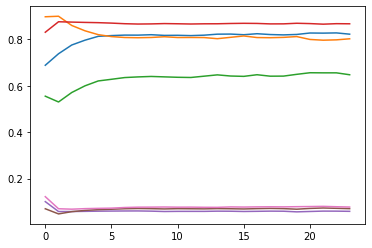

step: 0/2, D_loss: 3.3200996, G_loss_U: 0.32817334, G_loss_S: 0.028585697, E_loss_t0: 16.986084


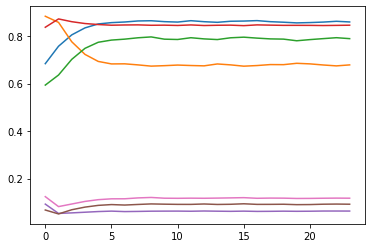

step: 0/2, D_loss: 2.6968398, G_loss_U: 0.47494116, G_loss_S: 0.02973614, E_loss_t0: 16.940548


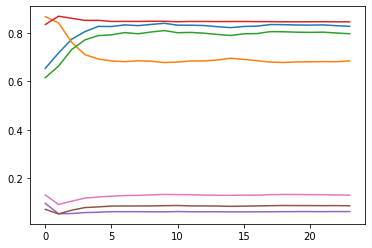

step: 0/2, D_loss: 2.2736912, G_loss_U: 0.64034593, G_loss_S: 0.031199308, E_loss_t0: 16.87038


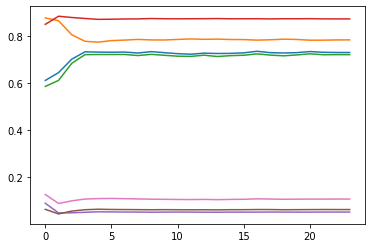

step: 1/2, D_loss: 1.9631473, G_loss_U: 0.8288132, G_loss_S: 0.036905408, E_loss_t0: 17.00172


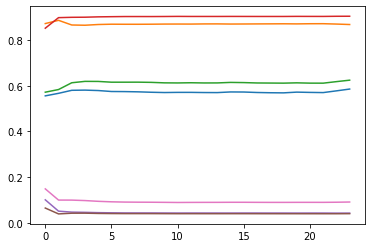

step: 1/2, D_loss: 1.9441978, G_loss_U: 0.8611117, G_loss_S: 0.03860827, E_loss_t0: 16.971617


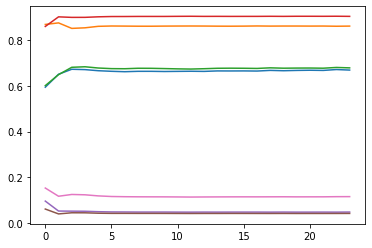

step: 1/2, D_loss: 1.9221145, G_loss_U: 0.8905837, G_loss_S: 0.040836986, E_loss_t0: 16.925638


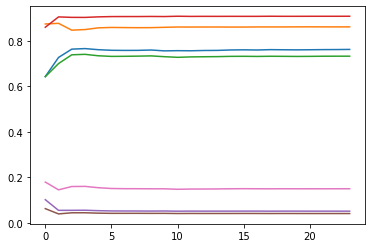

step: 1/2, D_loss: 1.898456, G_loss_U: 0.9185088, G_loss_S: 0.04302913, E_loss_t0: 16.85637


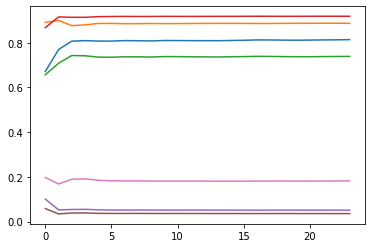

Finish Joint Training


In [ ]:
Generator, Embedder, Supervisor, Recovery, Discriminator, checkpoints = TimeGAN(data, parameters)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.007s...
[t-SNE] Computed neighbors for 2000 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.044662
[t-SNE] KL divergence after 300 iterations: 1.610959


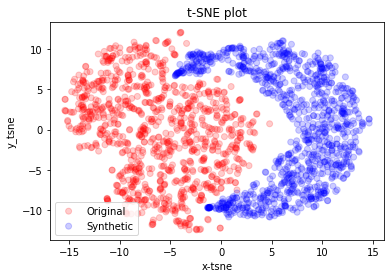

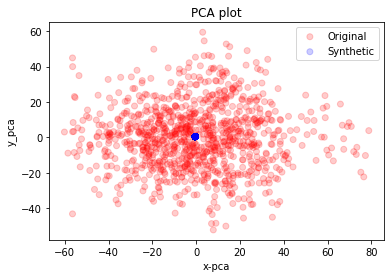

In [ ]:
random_test = random_generator(no, dim, extract_time(data)[0], extract_time(data)[1])
test_sample = Generator(torch.tensor(random_generator(no, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]
test_sample = torch.reshape(test_sample, (no, seq_len, parameters['hidden_dim']))
test_recovery = Recovery(test_sample)
test_recovery = torch.reshape(test_recovery[0], (no, seq_len, dim))
visualization(data, test_recovery.detach().numpy(), 'tsne')
visualization(data, test_recovery.detach().numpy(), 'pca')
  